In [146]:
import json
import pandas as pd
import numpy as np
import urllib
import pickle
import matplotlib.pyplot as plt
import math
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

Для меня это всё был новый материал для изучения и имплементации, так что часть времени была потрачена на просмотр лекций и чтения статей

In [2]:
# данные были размещены в корне папки, т.е. рядом с ноутбуком лежали папки entities и relations

persons_path = "entities/persons.idomaar" 
tracks_path = "entities/tracks.idomaar"
sessions_path = "relations/sessions.idomaar"
albums_path = "entities/albums.idomaar" 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
BATCH_SIZE = 8

Сразу про задачу. Мы представляем список прослушивания как предложение в классическом NLP, т.е. последовательность исполнителей это как последовательность слов.

Для начала я нашла все "" и заменила на \" все кавычки не относящиеся к json, что бы посмотреть на данные и понять их размеры, удалила несколько ячеек, где я просто смотрела на структуру данных и пыталась вытаскивать полезные данные.

In [20]:
fp = open(albums_path, 'r')
counter = 0
for line in fp:
    arr = line.split("\t")
    counter +=1
    if arr[3].count('"') > 8:        
        arr[3]  = arr[3].replace('""', '\\""', )
        index = arr[3].replace('"', 'X', 7).find('"')
        arr[3] = arr[3][:index] + '\\"' +arr[3][index+1:]
counter

2764474

Сохраним словарь вида трек-исполнитель для быстрого доступа к исполнителям

In [15]:
track_person_dict = {}
fp = open(tracks_path, 'r')
for line in fp:
    arr = line.split("\t")
    track_person_dict[arr[1]] = json.loads(arr[4])['artists'][0]['id']
with open('track_person_dict.pkl', 'wb') as f:
    pickle.dump(track_person_dict, f, pickle.HIGHEST_PROTOCOL)

KeyboardInterrupt: 

In [198]:
with open('track_person_dict.pkl', 'rb') as f:
    track_person_dict = pickle.load(f)

In [203]:
persons = (list(set(track_person_dict.values())))
print("Количество исполнителей: ", len(persons ))

Количество исполнителей:  560925


Сохраним данные в виде 'session_id','time','artist_id','playtime' в CSV файл (спойлер: это было не нужно)

In [25]:
full_df = pd.DataFrame(columns = ['session_id','time','artist_id','playtime'])
full = {}

fp = open(sessions_path, 'r')
counter = 0
for line in fp:
#     if counter > 5: break
    arr = line.split("\t")
    tracks_dict = json.loads(arr[3].split(' ')[1])
    for ob in tracks_dict['objects']:
        if ob['action'] == 'play':
                full[counter] = {'session_id':arr[1],
                                 'time':arr[2],
                                 'artist_id': track_person_dict[str(ob['id'])],
                                 'playtime':  ob['playtime']}
    counter +=1
    
    if counter % 100000 == 0:
        counter = 0
        full_df = full_df.append(pd.DataFrame.from_dict(full, "index"))
        full = {}
        print('->',full_df.shape, end='') 
full_df = full_df.append(pd.DataFrame.from_dict(full, "index"))

-> (80079, 4)-> (160110, 4)-> (240330, 4)-> (320243, 4)-> (400220, 4)-> (480110, 4)-> (559989, 4)-> (640280, 4)-> (720667, 4)-> (800881, 4)-> (880944, 4)-> (961053, 4)-> (1040960, 4)-> (1121173, 4)-> (1201302, 4)-> (1281696, 4)-> (1361756, 4)-> (1441866, 4)-> (1521821, 4)-> (1601814, 4)-> (1682099, 4)-> (1762109, 4)-> (1842173, 4)-> (1922341, 4)-> (2002336, 4)-> (2082240, 4)-> (2162253, 4)

In [26]:
full_df.to_csv('user_track_artist.csv')
full_df

,session_id,time,artist_id,playtime
0,287144,1390231051,306004,146
1,287145,1390241844,285794,785
2,287146,1390303249,15752,218
3,287147,1390481828,362467,190
4,287140,1421443687,46425,251
...,...,...,...,...
64467,2480035,1407944607,60947,234
64468,2480036,1407946794,114467,387
64469,2480037,1407955380,408202,74
64471,540638,1415960966,318259,319


In [3]:
full_df = pd.read_csv('user_track_artist.csv')

In [204]:
#тут у меня категорически не хватало памяти, поэтому я попробовала урезать список исполнителей и убрать тех кого
#мало слушают, но проблема с памятью решилась, также я думала что смогу применить такой подход на более сложных
#моделях, так как память ограничена, а сложность модели сильно растет.



# level = 50 #будем учитывать только артистов, которых слушали не менне level раз

# print(sum(full_df['artist_id'].value_counts() > level))
# short_persons = []

# for index, value in full_df['artist_id'].value_counts().items():
#     if value > level: short_persons.append(index)
# print(len(short_persons))

Составим списки исполнителей и словарь из названий исполнителя к его id

In [12]:
artists = np.unique(full_df['artist_id'])
artists_name_to_id = {}

counter = 0
fp = open(persons_path, 'r')
for line in fp:
    arr = line.split("\t")
    name = json.loads(arr[3])['name']
    counter += 1 
    artists_name_to_id[name] = arr[1]

Придумаем метрику для оценки результатов. Будем использовать эту метрику на обученных моделяхи валидационных данных для сравнения моделей.
Так как у нас задача предсказания следующего исполнителя, то логичным, кажется, исопльзовать что-то на подобие Discounted Cumulative Gain at K, так как неплохо было бы учитвать как правильность варианта, так и порядок.
Оценка будет суммой оценок состоящих из частоты встречи в датасете ответа который дала нам наша сеть деленного на место этого ответа. 

In [189]:
def metric(val_loader, model, k = 3, csv_path = 'bigrams.csv'): #работает только с batch_size = 1
    all_list = pd.read_csv(csv_path, index_col = 0)
    res_target_arr = []
    metric = 0
    n = 0
    
    for context, target in val_loader:
        
        context = context.to(device) 
        target = target.to(device) 
#         print(context.shape)
        res = model(context)
        
        neighbours = ((all_list.loc[all_list['context'] == context.cpu().numpy()[0]])['target'].value_counts())[:k]
#         print(neighbours)
        
        len_of_artist = len(all_list.loc[all_list['context'] == context.cpu().numpy()[0]])
        
#         print("соседи", neighbours.index.values.tolist())

        values, indices = torch.sort(res)
        np_indices = indices.cpu().numpy()[0]
        
        places = []
        tmp_metric = 0
        for i, neigh in enumerate(neighbours.index.values.tolist()):
            places.append(np.where(np_indices == neigh)[0][0])
            freq = 0
            try:
                freq = ((all_list.loc[all_list['context'] == context.cpu().numpy()[0]])['target'].value_counts())[neigh]/len_of_artist
            except KeyError:
                freq = 0
            tmp_metric += freq /(i+1)
            
            metric += tmp_metric
            
        n += 1
        break;
        if n % 1000 == 0: 
            print('->', end='')
    return  metric
    

Так как задача предсказывать из одного исполнителя другого, то нас интересуют биграммы из датасета, составим их и сохраним

In [ ]:
fp = open(sessions_path, 'r')
counter = 0

bigrams = []

bigrams_df =pd.DataFrame( columns = ["context", "target"] )

bigrams_df.to_csv('bigrams.csv')

for line in fp:
    arr = line.split("\t")
    tracks_dict = json.loads(arr[3].split(' ')[1])
    first, second = "", ""
    for i, ob in enumerate(tracks_dict['objects']):
        if len(tracks_dict['objects']) > 2:
            curr_artist =  track_person_dict[str(ob['id'])]
            if i == 0: first = curr_artist
            elif first != curr_artist:
                bigrams.append([first,curr_artist])
                first = curr_artist
            else: first = curr_artist
    counter +=1   
    if counter % 100000 == 0:
        bigrams_df = pd.DataFrame( columns = ["target","context"], data = bigrams)
#         context_df = pd.DataFrame( columns = ["context"], data = context)
        bigrams_df.to_csv('bigrams.csv', mode='a', header=False)
        print('->', len(bigrams), end = '')
        bigrams = []
bigrams_df = pd.DataFrame( columns = ["target","context"], data = bigrams)
bigrams_df.to_csv('bigrams.csv', mode='a', header=False)

Для удобства я обернула данные в класс из torch, так удобнее обучать модель

In [5]:
class Bigram_dataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.transform = transform
        csv = pd.read_csv(csv_file, index_col = 0)
        self.tensor_target_data = torch.from_numpy( csv['target'].values.astype(np.int64)  )
        self.tensor_context_data = torch.from_numpy(csv['context'].values.astype(np.int64)  )
        
    def __len__(self):
        return len(self.tensor_target_data)
    def __getitem__(self, idx):
        return (self.tensor_context_data[idx], self.tensor_target_data[idx])
    
ds = Bigram_dataset('bigrams.csv')
print(len(ds))

/home/ev-gud/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


13326355


In [176]:
TrainData, ValidationData = random_split(ds, [int(len(ds)*0.95), len(ds)-int(len(ds)*0.95)])
trainloader = DataLoader(TrainData, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(ValidationData, batch_size=BATCH_SIZE, shuffle=True)

Первая, довольно простая модель и её тренировка:

In [7]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = 100
VOCAB_SIZE = int(artists[-1])


class EasyEmbeddingModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(EasyEmbeddingModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.linear1 = nn.Linear(context_size * embedding_dim, vocab_size)
        self.norm = nn.BatchNorm1d(vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = self.norm(self.linear1(embeds))
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [ ]:
epochs = 1
losses = []
batch_losses = []
loss_function = nn.NLLLoss()
model = EasyEmbeddingModel(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
for epoch in range(epochs):
    total_loss = 0
    counter = 0
    
    for context, target in trainloader:
        context = context.to(device) 
        target = target.to(device) 
        
        model.zero_grad()

        log_probs = model(context)

        loss = loss_function(log_probs, target)

        loss.backward()
        
        optimizer.step()
        
        
        
        if counter % 1000 == 0:
            batch_losses.append(loss.item())
            print('batch_loss', loss.item(), torch.argmax(log_probs, dim = 1)[0])
#             print('batch_loss', loss.item(), torch.argmax(log_probs, dim = 1)[0])
        counter += 1
        total_loss += loss.item()
    print('EPOCH', epoch , 'loss', total_loss)
    losses.append(total_loss)

batch_loss 11.682075500488281 tensor(82955, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 11.056111335754395 tensor(124222, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 15.885376930236816 tensor(228054, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 12.587739944458008 tensor(228054, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 12.509746551513672 tensor(286091, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 12.088662147521973 tensor(286091, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 10.387239456176758 tensor(56683, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 12.299520492553711 tensor(192147, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 8.808643341064453 tensor(192147, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 13.092257499694824 tensor(286091, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 11.176526069641113 tensor(310487, device='cuda:0', grad_fn=<SelectBackward>)
batch_loss 11.893946647644043 tenso

KeyboardInterrupt: 

In [21]:
torch.save(model.state_dict(), 'bigram_model_10eph_small_model2.pth')

Значения лосса и график, выглядит не вдохновляюще, однако посмотрим на результаты по другому

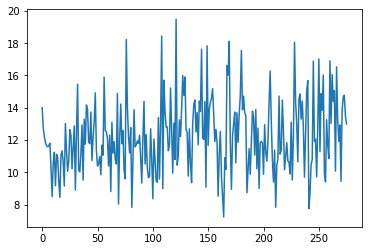

In [20]:
plt.plot(batch_losses)
plt.show()

In [192]:
testloader = DataLoader(ValidationData, batch_size=1, shuffle=True)
print('Длина датасета, на котором будем тестить: ',len(testloader))
print("Значение метрики:", metric(testloader, model, k = 3))

Длина датасета, на котором будем тестить:  666318
Значение метрики: 0.1961492178098676


In [193]:
# name = 'bigram_model_10eph_small_model.pth'
# model = EasyEmbeddingModel(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE).to(device)   
# model.load_state_dict(torch.load(name))

In [15]:
def get_top_k(model, k, artist_name):
    artist_id = int(artists_name_to_id[artist_name])
    model.eval()
    res = model(torch.tensor([artist_id], dtype = torch.int64).to(device)).cpu()
    values, indices = torch.topk(res, 20)

    names = ["" for i in range(20)]
    for name, ar_id in artists_name_to_id.items():
        if int(ar_id) in indices: 
            index = np.where(indices == int(ar_id))
            names[index[1][0]] = urllib.parse.unquote(name)
    return names

In [195]:
acdc_similar = get_top_k(model, 20, "ACDC")
madonna_similar = get_top_k(model, 20, "Madonna")
bonjovi_similar = get_top_k(model, 20, "Bon+Jovi")
Rihanna_similar = get_top_k(model, 20, "Rihanna")

In [196]:
print(acdc_similar, end = '\n\n')
print(madonna_similar, end = '\n\n')
print(bonjovi_similar, end = '\n\n')
print(Rihanna_similar, end = '\n\n')

['Metallica+&+Korn', 'Queen+&+Wyclef+Jean+(featuring+Pras+Michael+&+Free)', 'Aerosmith+&+Carrie+Underwood', 'The+Beatles,+Brian+Matthew', 'Hardline', 'AC+DC', 'R+U+S+H', 'Iron+Maiden', 'Deep+Purple', 'Judas+Priest', 'Freddie+Mercury+&+Montserrat+Caballé', 'Alice+Cooper+&+Ozzy+Osbourne+&+Joe+Satriani+&+Slash', 'Blind+Guardian', 'Europe', 'Nazareth', 'Manowar', 'Bon+Jovi', 'Pink+Floud', 'Nirvana', 'Def+Leppard']

["Lady+Gaga+Featuring+Colby+O'Donis", 'britney+spears+feat.+pharrel+williams', 'Madonna&Justin+Timberlake', 'Marina+&+the+Diamonds', 'Mariah+Carey+feat.+Twista', 'Lorde', 'Lana+Del+Rey+(www.hitov.ru)', 'Rihanna+feat.+Drake', 'Katy+Perry+-+www.SongsLover.com', 'David+Guetta+&+Avicii+vs.+Laidback+Luke', 'Ellie+Goulding', 'Beyonce', 'Maroon+5+&+Christina+Aguilera', 'Kylie+Minogue+&+Nick+Kave', 'Nico+&+Vlad', 'Coldplay', 'Clean+Bandit+feat.+Stylo+G', 'Michael+Jackson;', 'Taylor+Swift+feat.+The+Civil+Wars', 'Black+Keys+&+Dirty+Streets']

['Queen+&+Wyclef+Jean+(featuring+Pras+Michael+

По этим первичным результатам видно, что данные на самом деле очень грязные и содержат не только имена исполнителей, но иногда и всякий мусор, а также было замечено что имена одинаковых исполнителей погут повторятся с небольшими изменинеиями (вроде отсутсвия пробела или других символов), кажется, такое надо вычищать из датасета вручную.
А так же под одними и теми же id скрываются несколько имен, поэтому можно встретить песни с двумя авторами в списке выше, но они в данных обозначены одним id, на сколько я понимаю, первым исполнителем в списке.
Еще так как я взяла за размер словоря последний id, то не все id на самом деле существуют в датасете, но их там относительно немного.

Из этих результатов можно увидеть, что похожие исполнители для этих музыкантов разные и в общем, хочется сказать что даже похожи на правду. 
Так как я впервые реализовывала подобный функционал, я лишь читала о более сложных моделях и не дошла до их имплементации. (читала про DLRM, RNN based подходы, и в общем разные статьи про item-to-item recommendation)